In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Load your data
data = pd.read_csv('C:\\Users\\Steven Cochrane\\Desktop\\data-viz\\bmiData.csv')

# Dropping the 'id' column
data.drop('id', axis=1, inplace=True)


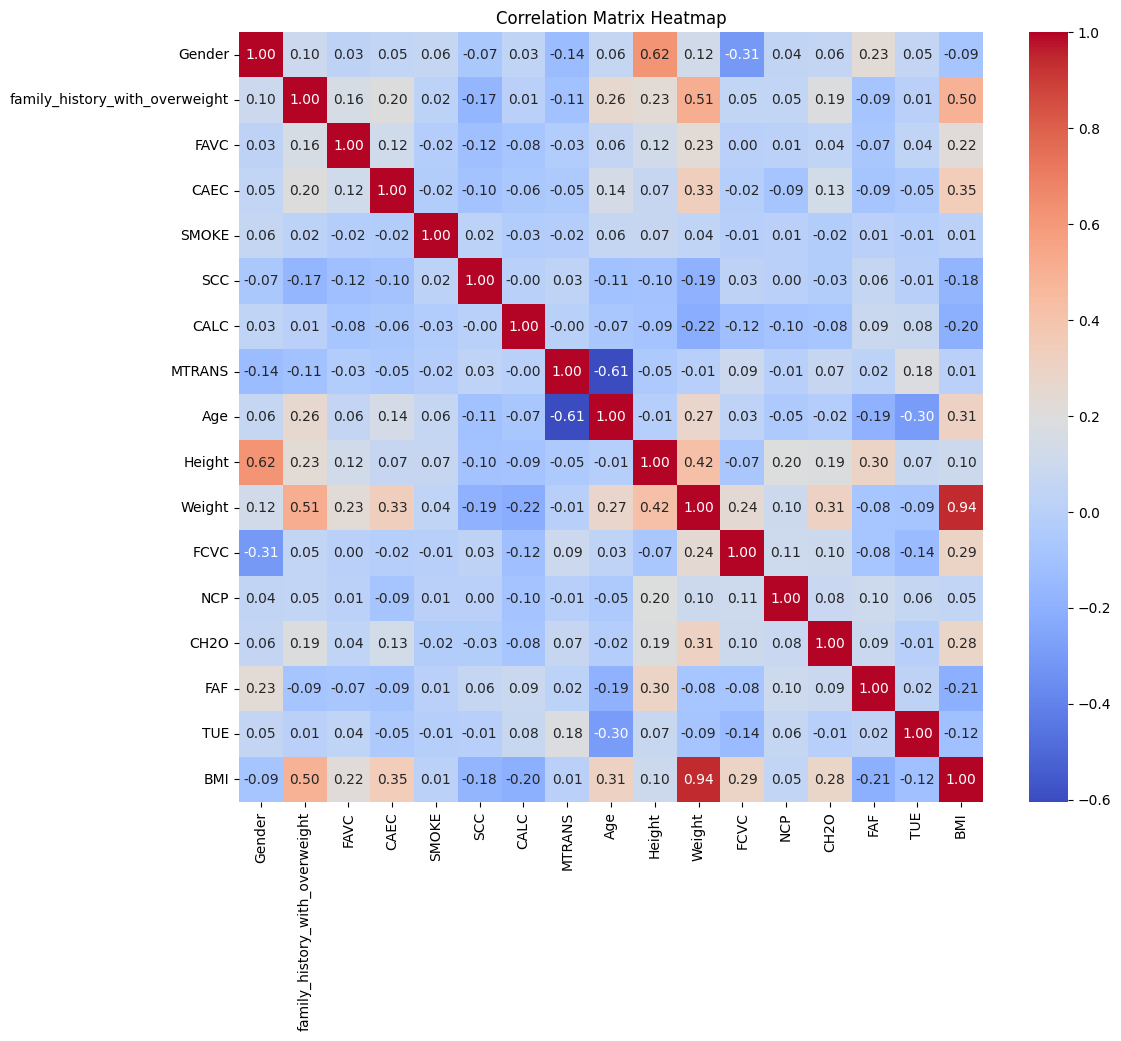

In [34]:
# Calculate correlation matrix
corr = data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()


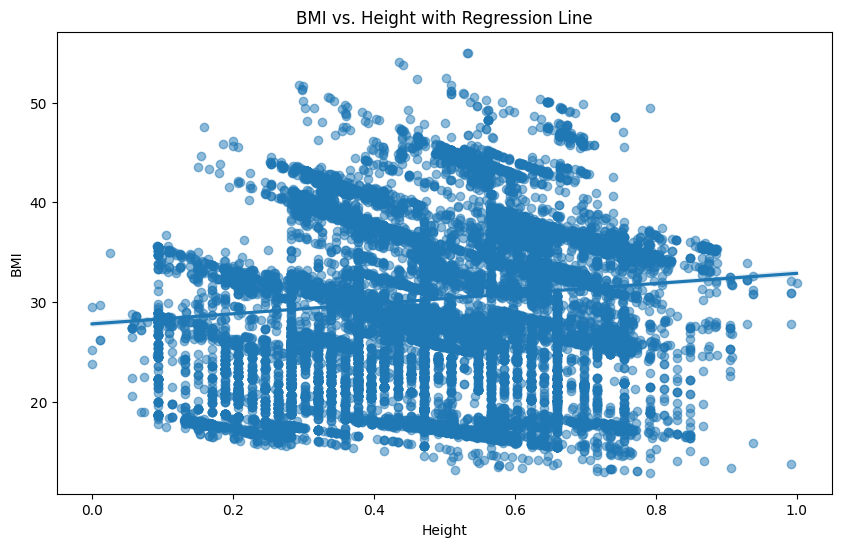

In [10]:
plt.figure(figsize=(10, 6))
sns.regplot(x='Height', y='BMI', data=data, scatter_kws={'alpha':0.5})
plt.title('BMI vs. Height with Regression Line')
plt.xlabel('Height')
plt.ylabel('BMI')
plt.show()



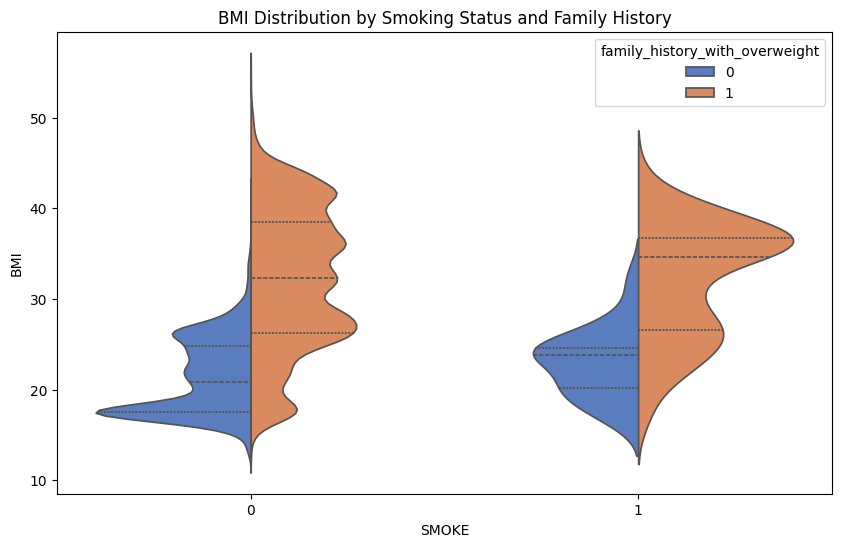

In [11]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='SMOKE', y='BMI', hue='family_history_with_overweight', data=data, split=True, inner="quart", palette="muted")
plt.title('BMI Distribution by Smoking Status and Family History')
plt.show()

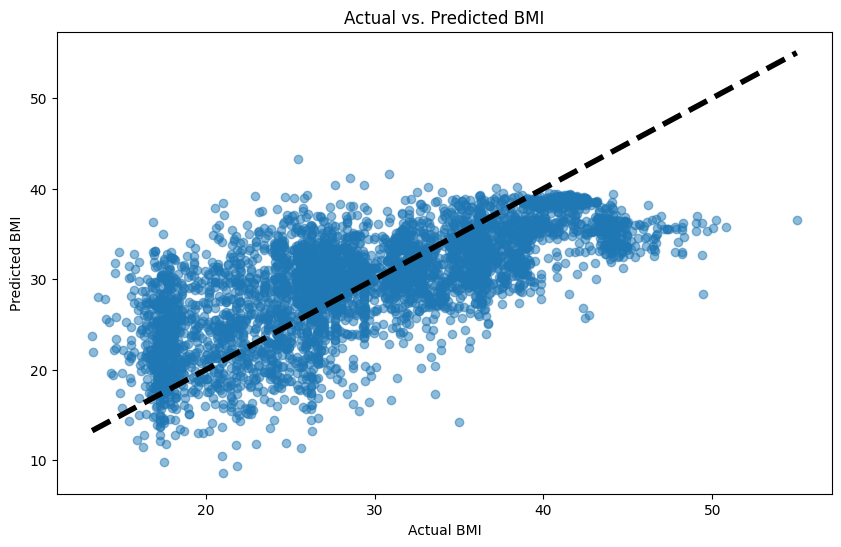

In [13]:
# Prepare your data
X = data.drop(['BMI', 'Weight'], axis=1)  # Dropping 'Weight' to make it more interesting
y = data['BMI']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
predictions = model.predict(X_test)

# Visualizing the model predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Line representing perfect predictions
plt.title('Actual vs. Predicted BMI')
plt.xlabel('Actual BMI')
plt.ylabel('Predicted BMI')
plt.show()


In [15]:
# Assuming 'model' is your trained LinearRegression model
intercept = model.intercept_
coefficients = model.coef_

# Equation string
equation = f"BMI = {intercept:.2f} "
equation += " + ".join([f"{coef:.2f} * {feat}" for coef, feat in zip(coefficients, X.columns)])

print("Linear Regression Equation:")
print(equation)


Linear Regression Equation:
BMI = 4.71 -1.51 * Gender + 7.15 * family_history_with_overweight + 2.92 * FAVC + 3.72 * CAEC + 0.15 * SMOKE + -2.74 * SCC + -1.76 * CALC + 1.43 * MTRANS + 19.09 * Age + 3.24 * Height + 5.92 * FCVC + 0.81 * NCP + 4.05 * CH2O + -2.65 * FAF + -0.71 * TUE


In [21]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

# Assuming you're interested in clustering based on 'Height' and 'BMI'
features = data[['Height', 'BMI']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply MiniBatchKMeans
mini_kmeans = MiniBatchKMeans(n_clusters=3, random_state=42)
clusters = mini_kmeans.fit_predict(features_scaled)

# Visualize the clusters
plt.scatter(features['Height'], features['BMI'], c=clusters, cmap='viridis')
plt.xlabel('Height')
plt.ylabel('BMI')
plt.title('MiniBatchKMeans Clustering of BMI Data')
plt.show()

ImportError: cannot import name '_fit_context' from 'sklearn.base' (c:\Users\Steven Cochrane\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py)

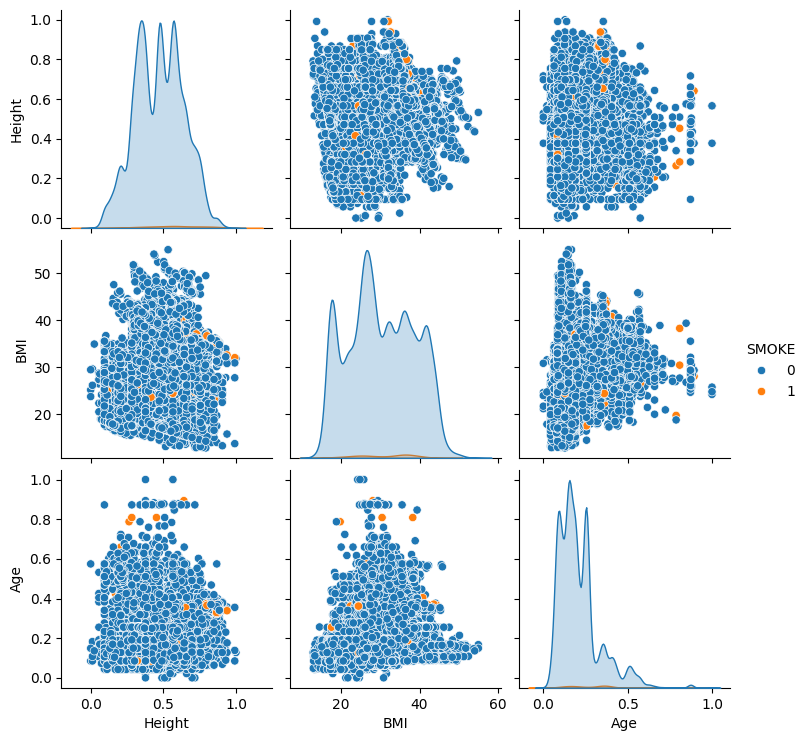

In [17]:
sns.pairplot(data, vars=['Height', 'BMI', 'Age'], hue='SMOKE')
plt.show()

C:\Users\Steven Cochrane\AppData\Local\Temp\ipykernel_20616\3148400618.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['BMI'])


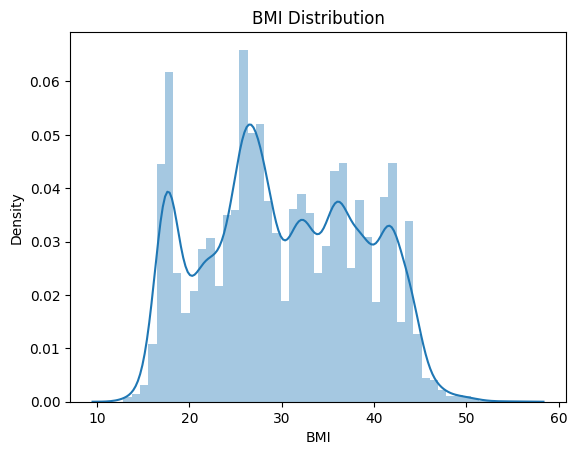

In [22]:
sns.distplot(data['BMI'])
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Density')
plt.show()

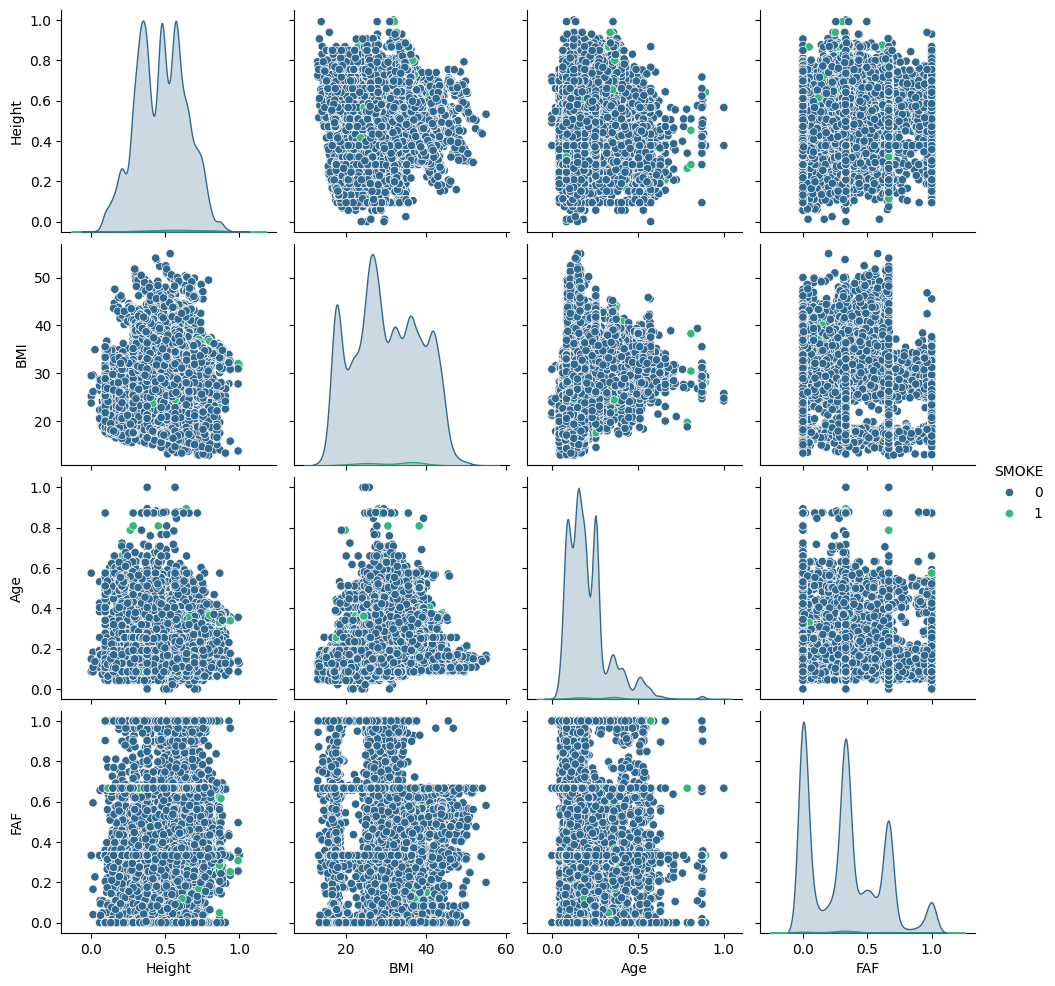

In [27]:
# Adjust 'vars' to focus on variables of interest
sns.pairplot(data, vars=['Height', 'BMI', 'Age', 'FAF'], hue='SMOKE', diag_kind='kde', kind='scatter', palette='viridis')
plt.show()


C:\Users\Steven Cochrane\AppData\Local\Temp\ipykernel_20616\3737313976.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test, hist=False, kde=True,
c:\Users\Steven Cochrane\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\Steven Cochrane\AppData\Local\Temp\ipykernel_20616\3737313976.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn

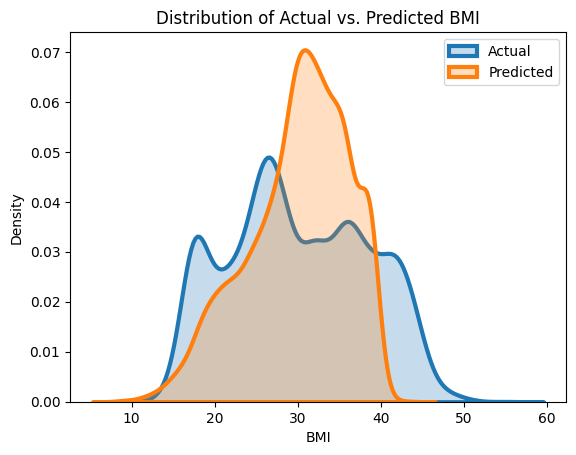

In [28]:
# Assuming 'predictions' from your regression and actual 'y_test' values
sns.distplot(y_test, hist=False, kde=True, 
             kde_kws={'shade': True, 'linewidth': 3}, 
             label='Actual')
sns.distplot(predictions, hist=False, kde=True, 
             kde_kws={'shade': True, 'linewidth': 3},
             label='Predicted')
plt.title('Distribution of Actual vs. Predicted BMI')
plt.legend()
plt.show()


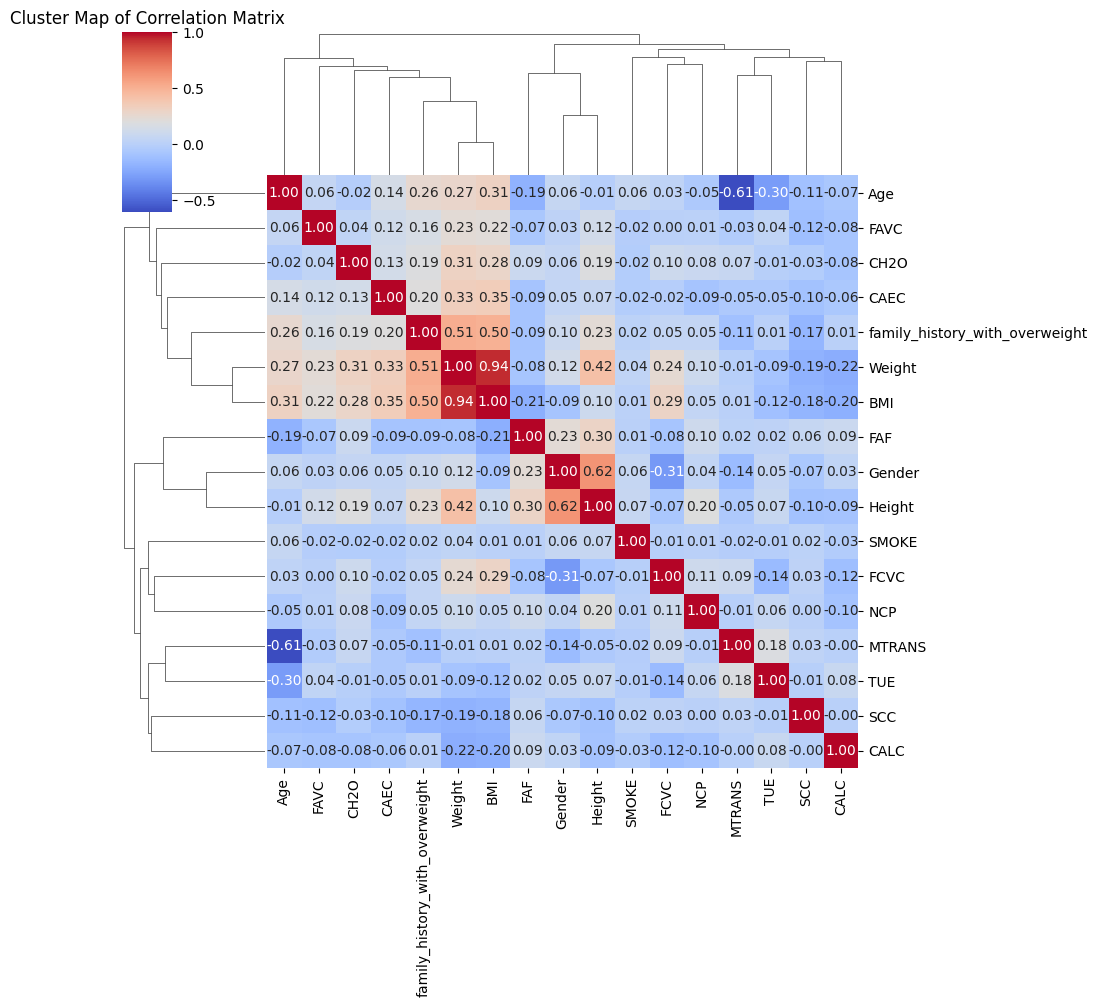

In [29]:
sns.clustermap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm', figsize=(10, 10))
plt.title('Cluster Map of Correlation Matrix')
plt.show()


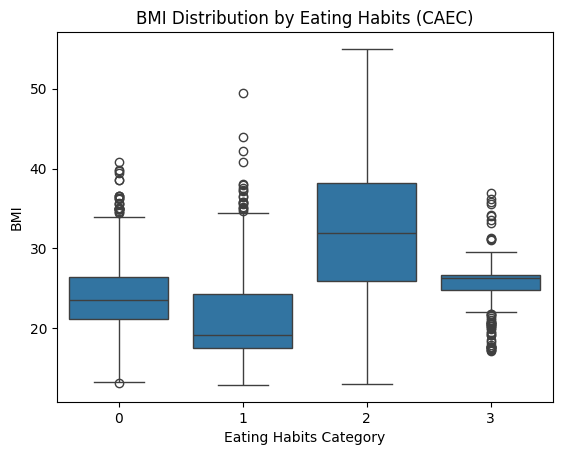

In [30]:
sns.boxplot(x='CAEC', y='BMI', data=data)
plt.title('BMI Distribution by Eating Habits (CAEC)')
plt.xlabel('Eating Habits Category')
plt.ylabel('BMI')
plt.show()


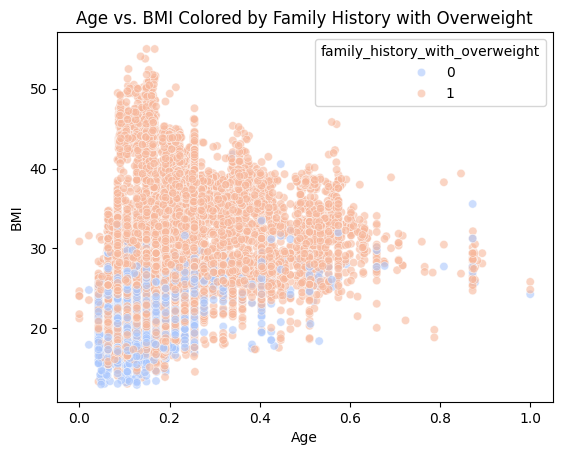

In [31]:
sns.scatterplot(x='Age', y='BMI', hue='family_history_with_overweight', data=data, palette='coolwarm', alpha=0.6)
plt.title('Age vs. BMI Colored by Family History with Overweight')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.show()
